In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Dataset

In [4]:
progeria = pd.read_csv(r"C:\Users\amulya\Documents\progeria-prediction\230705_progeria_c2\IdentifyPrimaryObjects.csv")
normal = pd.read_csv(r"C:\Users\amulya\Documents\progeria-prediction\230705_normal_c2\IdentifyPrimaryObjects.csv")
cols_to_drop = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
progeria_features = progeria.drop(columns=cols_to_drop)
progeria_features = progeria_features.assign(label=1) 
normal_features = normal.drop(columns=cols_to_drop)
normal_features = normal_features.assign(label=0) 
full_data = pd.concat([progeria_features, normal_features],axis=0)
full_data = full_data.replace([np.inf, -np.inf], np.nan)
full_data = full_data.dropna()

In [5]:
class CellFeaturesDataset(Dataset):
    def __init__(self, fulldata, transform=None, target_transform=None):
        self.labels = fulldata.loc[:,'label'].values
        self.data = fulldata.loc[:,~fulldata.columns.isin(['label'])].values
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item = self.data[idx,:]
        label = self.labels[idx]
        if self.transform:
            item = self.transform(item)
        if self.target_transform:
            label = self.target_transform(label)
        return item.float(), label.float()

## Transform data - scale and convert to tensor

In [6]:
def tensor_and_scale (x):
    m = x.mean(0)
    s = x.std(0)
    x -= m
    x /= s
    # torch.allclose(x, torch.from_numpy(arr_norm))
    return torch.as_tensor(x)

t = tensor_and_scale

In [7]:
cell_dataset = CellFeaturesDataset(full_data, transform=t, target_transform=torch.as_tensor)

## Train-test split, create dataloaders

In [8]:
from sklearn.model_selection import train_test_split

train_cells, test_cells = train_test_split(cell_dataset, stratify=cell_dataset.labels, test_size=0.35)

In [9]:
batch_size = 32

#sampler = torchsample.StratifiedSampler(class_vector=cell_dataset.labels, batch_size=batch_size)
#test_cells, train_cells = torch.utils.data.random_split(cell_dataset, [.3, .7])
train_dataloader = DataLoader(train_cells, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_cells, batch_size=batch_size, shuffle=True)

# ANN

In [209]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=58, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=2),
        )

    def forward(self, x):
        # do stuff here
        logits = self.linear_relu_stack(x)
        prediction = torch.sigmoid(logits)
        return prediction

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [216]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.float()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long())
        # Backpropagation
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [217]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Run

In [228]:
learning_rate = 1e-6
epochs = 5
loss_fn = nn.NLLLoss()
reg_fn = nn.L1Loss()
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: -0.000001  [   32/ 1570]
Test Error: 
 Accuracy: 97.0%, Avg loss: -0.001747 

Epoch 2
-------------------------------
loss: -0.000054  [   32/ 1570]
Test Error: 
 Accuracy: 97.0%, Avg loss: -0.001747 

Epoch 3
-------------------------------
loss: -0.000101  [   32/ 1570]
Test Error: 
 Accuracy: 97.0%, Avg loss: -0.001748 

Epoch 4
-------------------------------
loss: -0.028369  [   32/ 1570]
Test Error: 
 Accuracy: 97.0%, Avg loss: -0.001748 

Epoch 5
-------------------------------
loss: -0.002635  [   32/ 1570]
Test Error: 
 Accuracy: 97.0%, Avg loss: -0.001749 

Done!


# Logistic regression

In [10]:
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        torch.nn.init.uniform_(self.linear.weight, -0.01, 0.01) 
        torch.nn.init.zeros_(self.linear.bias)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [11]:
def train (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X)
        outputs = model(X)
        loss = loss_fn(outputs, y.long())
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output, y.long())
            loss.backward()
            return loss
        optimizer.step(closure)
        current = (batch + 1) * len(X)
        print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    print(loss.item())
    return loss.item()

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(y)
            test_loss += loss_fn(outputs, y.long()).item()
            correct += (predicted == y).sum()
    accuracy = 100 * (correct) / len(dataloader.dataset)
    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct/size):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy, test_loss

## Run

In [14]:
log_regr = LogisticRegression(58, 2)
loss_fn = torch.nn.NLLLoss()
learning_rate = 1e-3
optimizer = torch.optim.LBFGS(log_regr.parameters(), lr=learning_rate)
epochs = 20

losses = []
accs = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    l_t = train(train_dataloader, log_regr, loss_fn, optimizer)
    a_t, tl_t = test(test_dataloader, log_regr, loss_fn)
    losses.append(l_t)
    accs.append(a_t)
    test_losses.append(tl_t)
print("Done!")

Epoch 1
-------------------------------
loss: -0.505101  [   32/ 1457]
loss: -0.570015  [   64/ 1457]
loss: -0.603895  [   96/ 1457]
loss: -0.624365  [  128/ 1457]
loss: -0.641545  [  160/ 1457]
loss: -0.657063  [  192/ 1457]
loss: -0.672243  [  224/ 1457]
loss: -0.681801  [  256/ 1457]
loss: -0.694013  [  288/ 1457]
loss: -0.699303  [  320/ 1457]
loss: -0.711879  [  352/ 1457]
loss: -0.722097  [  384/ 1457]
loss: -0.731933  [  416/ 1457]
loss: -0.739088  [  448/ 1457]
loss: -0.750030  [  480/ 1457]
loss: -0.755196  [  512/ 1457]
loss: -0.752699  [  544/ 1457]
loss: -0.768539  [  576/ 1457]
loss: -0.777052  [  608/ 1457]
loss: -0.778547  [  640/ 1457]
loss: -0.788474  [  672/ 1457]
loss: -0.787958  [  704/ 1457]
loss: -0.798656  [  736/ 1457]
loss: -0.803394  [  768/ 1457]
loss: -0.807368  [  800/ 1457]
loss: -0.814986  [  832/ 1457]
loss: -0.816696  [  864/ 1457]
loss: -0.820832  [  896/ 1457]
loss: -0.821142  [  928/ 1457]
loss: -0.828130  [  960/ 1457]
loss: -0.834531  [  992/ 1457]

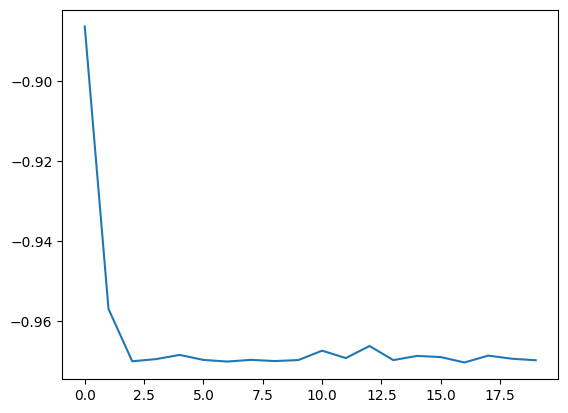

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)

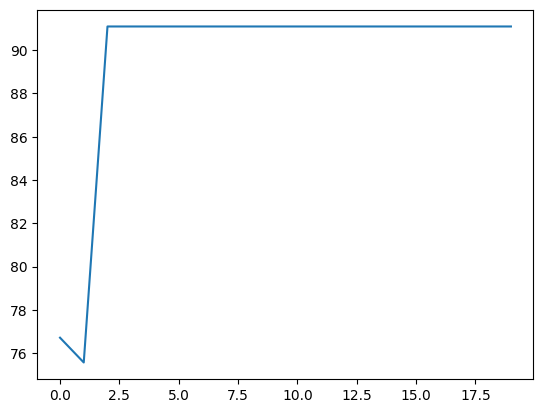

In [16]:
plt.plot(accs)

In [498]:
print(accs)

[tensor(44.9109), tensor(16.0305), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483), tensor(17.0483)]
